In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Copying reduced dataset from drive because loading directly from drive is too slow
!cp -r '/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Reduced_dataset.zip' '/content/'
!unzip "/content/Reduced_dataset.zip" -d '/content/dataset'
dataset='/content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset'

Archive:  /content/Reduced_dataset.zip
   creating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/
   creating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/
  inflating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/278.jpg  
  inflating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/178.jpg  
  inflating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/with_mask252.jpg  
  inflating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/with_mask045.jpg  
  inflating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/with_mask653.jpeg  
  inflating: /content/dataset/content/drive/MyDrive/FaceMask/Face Mask Dataset/Reduced_Train/dataset/WithMask/0_0_1 copy

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 16
early_stopping = EarlyStopping(
    monitor='val_acc', 
    patience=3, 
    min_delta=0.001, 
    mode='auto')
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/FaceMask/Model VGG16/model-{epoch:03d}.model',save_freq='epoch',monitor='val_acc',verbose=1,save_best_only=True,mode='auto')

In [ ]:

print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
print(labels)

[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


['WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutM

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,	metrics=["acc"])
for layer in baseModel.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,	metrics=["acc"])
#train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
	callbacks=[checkpoint,early_stopping])

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
204/204 [==============================] - ETA: 0s - loss: 0.1319 - acc: 0.9524WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 51 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_acc improved from -inf to 0.97680, saving model to /content/gdrive/MyDrive/FaceMask/Model VGG16/model-001.model
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/FaceMask/Model VGG16/model-001.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


204/204 [==============================] - 84s 359ms/step - loss: 0.1319 - acc: 0.9524 - val_loss: 0.0687 - val_acc: 0.9768
Epoch 2/10
204/204 [==============================] - 41s 202ms/step - loss: 0.0630 - acc: 0.9834
Epoch 3/10
204/204 [==============================] - 41s 203ms/step - loss: 0.0515 - acc: 0.9837
Epoch 4/10
204/204 [==============================] - 41s 202ms/step - loss: 0.0447 - acc: 0.9846
Epoch 5/10
204/204 [==============================] - 41s 201ms/step - loss: 0.0346 - acc: 0.9902
Epoch 6/10
204/204 [==============================] - 41s 202ms/step - loss: 0.0315 - acc: 0.9877
Epoch 7/10
204/204 [==============================] - 42s 203ms/step - loss: 0.0381 - acc: 0.9862
Epoch 8/10
204/204 [==============================] - 41s 203ms/step - loss: 0.0345 - acc: 0.9877
Epoch 9/10
204/204 [==============================] - 41s 203ms/step - loss: 0.0344 - acc: 0.9862
Epoch 10/10
204/204 [==============================] - 41s 202ms/step - loss: 0.0268 - acc: 

[INFO] evaluating network...
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       433
 WithoutMask       0.99      1.00      1.00       386

    accuracy                           1.00       819
   macro avg       1.00      1.00      1.00       819
weighted avg       1.00      1.00      1.00       819



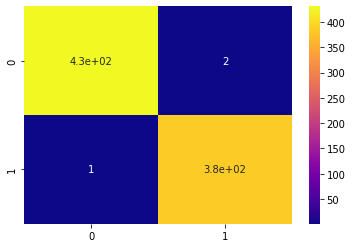

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score
import seaborn as sns
cm=confusion_matrix(testY.argmax(axis=1),predIdxs)
from sklearn.metrics import classification_report
sns.heatmap(cm,cmap="plasma",annot=True)

In [ ]:
model.save("/content/gdrive/MyDrive/FaceMask/FM_MobileNetV2.h5")


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


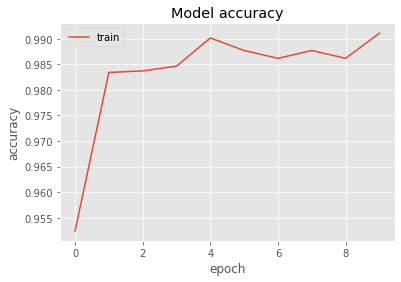

In [ ]:
plt.plot(H.history['acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

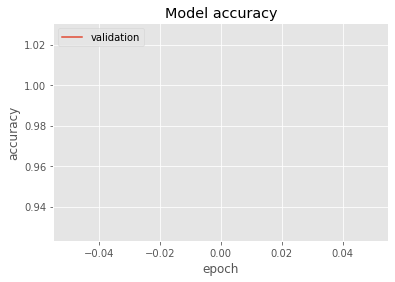

In [ ]:
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'],loc='upper left')
plt.show()

ROC Curve

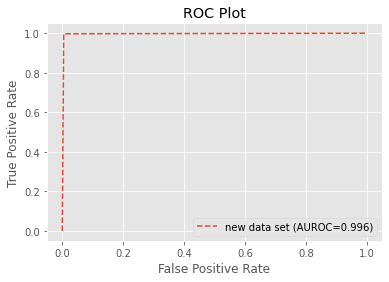

In [ ]:
#plotting ROC curve 
r_auc_new_dataset=roc_auc_score(testY.argmax(axis=1),predIdxs)
r_fpr_new_dataset,r_tpr_new_dataset,_=roc_curve(testY.argmax(axis=1),predIdxs)
plt.plot(r_fpr_new_dataset,r_tpr_new_dataset,linestyle='--',label='new data set (AUROC=%0.3f)' %r_auc_new_dataset)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
#infite loop to avoid collab runtime from shuttingdown after training
while True:pass